# SGD and its Variants: Demonstration

In this notebook we will try out a few of the SGD variants in a 2D setting.
We will let the algorithms try to find the minimum in 2D landscapes that have various features that make life difficult.

In [1]:
 # standard libraries
import math, os, time, glob
import numpy as np

# plotting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# PyTorch
import torch
import torch.nn as nn # lets not write out torch.nn every time
import torch.nn.functional as F # functional versions of the modules in torch.nn
from torch.optim import SGD, Adagrad, RMSprop, Adam # the SGD algorithms we will be testing

We will construct 4 loss landscapes.
1) __Canyon__: not all parameters contribute to the end result in equal measure.
2) __Saddle__: saddle points are know to be present in large numbers in NN loss functions.
3) __Plateau__: the loss landscape may contain flat plateaus where the gradient vanishes.
4) __Obstacle__: there may not be a direct route to the local minimum.

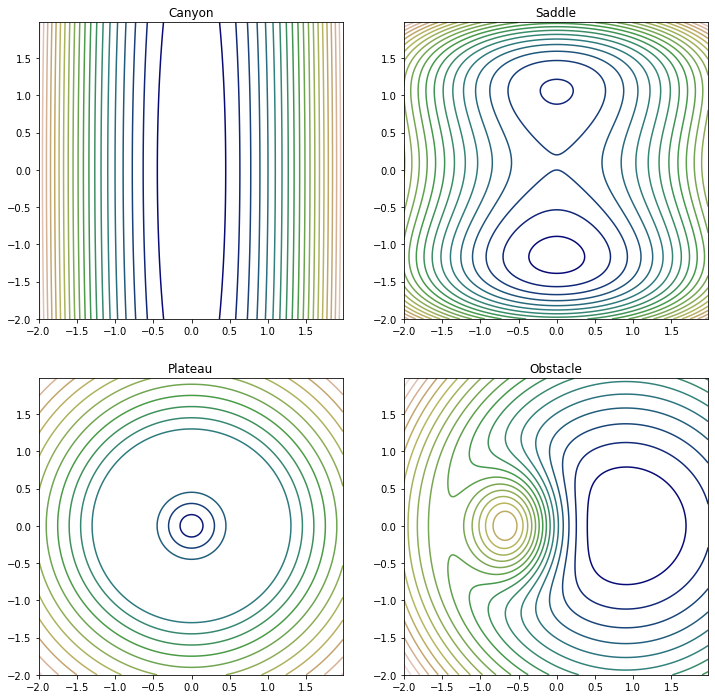

In [2]:
# define the loss functions

canyon = lambda X, Y: X**2 + (1.0/60.0) * Y**2

saddle = lambda X, Y: (X**2 - Y**2 + 0.4 * Y**4 + 0.2*Y)/6

plateau = lambda X, Y: (
    (X**2 + Y**2).sqrt() 
    - ((X**2 + Y**2).sqrt()-0.5).relu() 
    + ((X**2 + Y**2).sqrt()-1.2).relu()
)

obstacle = lambda X, Y: (
    0.4 * ((X-0.9)**2 + Y**2) 
    + 3.0 * torch.exp(-3*((X+0.6)**2 + (0.8*Y)**2))
)

# plot the functions

X, Y = torch.meshgrid(torch.arange(-2, 2, 0.02), torch.arange(-2, 2, 0.02))


plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.contour(X, Y, canyon(X,Y), levels=20, cmap='gist_earth')
plt.gca().set_title('Canyon')
plt.subplot(2, 2, 2)
plt.contour(X, Y, saddle(X,Y), levels=20, cmap='gist_earth')
plt.gca().set_title('Saddle')
plt.subplot(2, 2, 3)
plt.contour(X, Y, plateau(X,Y), levels=20, cmap='gist_earth')
plt.gca().set_title('Plateau')
plt.subplot(2, 2, 4)
plt.contour(X, Y, obstacle(X,Y), levels=20, cmap='gist_earth')
plt.gca().set_title('Obstacle')
plt.show()

In [3]:
"""
    Starting from `p0` descend `f` using SGD, SGD with momentum, Adagrad, RMSprop, Adam.
    Returns the 5 paths each algorithm took through the landscape.
"""
def train(f, p0, epochs):
    params = [torch.tensor(p0, requires_grad=True) for i in range(5)]
    optimizers = [SGD((params[0],), lr=0.2), SGD((params[1],), lr=0.2, momentum=0.6), Adagrad((params[2],), lr=0.3), RMSprop((params[3],), lr=0.025), Adam((params[4],), lr=0.1)]
    
    # to make this slightly more realistic we will add some noise to the gradient every epoch
    noise_dist = torch.distributions.uniform.Uniform(-0.06, 0.06)
    
    paths = np.array([p0 for p in params])
    
    for epoch in range(1, epochs+1):
        
        noise = noise_dist.sample([2]) # generate a new noise vector every epoch
        
        for (p, opt) in zip(params, optimizers):
            opt.zero_grad()
            loss = f(p[0], p[1])
            loss.backward()
            p.grad += noise # add the noise to the parameters' gradient
            opt.step()
            paths = np.concatenate((paths, [p.detach().numpy(),]))
    
    return paths.reshape((-1, len(params), 2)).transpose(1, 0, 2)


"""
    Uses the `train` function to calculate the paths all the algorithms took through the landscape given by the function 'f'.
    Subsequently plots the paths on the loss landscape.
"""
def plot_paths(f, p0, epochs, ax, title):
    paths = train(f, p0, epochs)
    
    ax.set_title(title)
    ax.contour(X, Y, f(X,Y), levels=30, cmap='Greys_r')
    ax.plot(paths[0,...,0], paths[0,...,1], label='SGD')
    ax.plot(paths[1,...,0], paths[1,...,1], label='SGD w. momentum')
    ax.plot(paths[2,...,0], paths[2,...,1], label='Adagrad')
    ax.plot(paths[3,...,0], paths[3,...,1], label='RMSprop')
    ax.plot(paths[4,...,0], paths[4,...,1], label='Adam')
    s = 300
    ax.scatter(paths[0, -1, 0], paths[0, -1, 1], s, marker='.')
    ax.scatter(paths[1, -1, 0], paths[1, -1, 1], s, marker='.')
    ax.scatter(paths[2, -1, 0], paths[2, -1, 1], s, marker='.')
    ax.scatter(paths[3, -1, 0], paths[3, -1, 1], s, marker='.')
    ax.scatter(paths[4, -1, 0], paths[4, -1, 1], s, marker='.')
    ax.legend()
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))

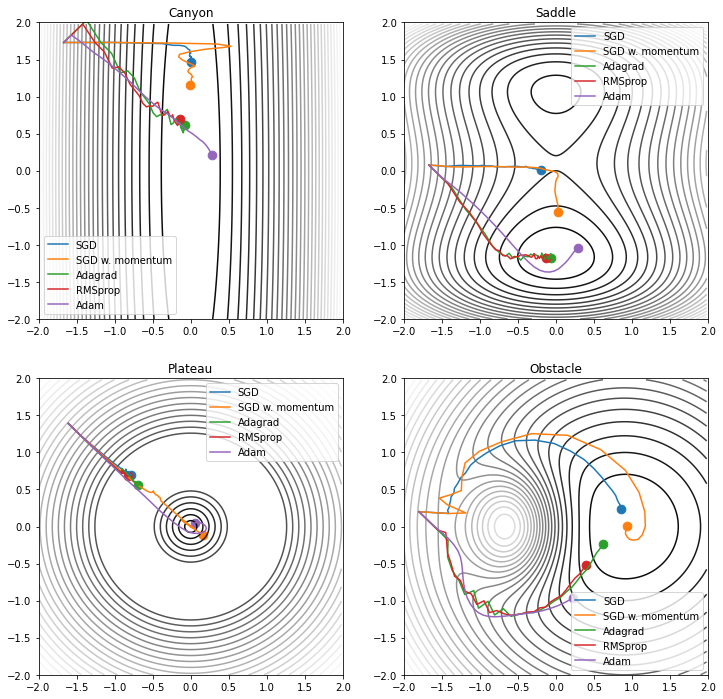

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

plot_paths(canyon, [-1.67, 1.73], 30, ax1, 'Canyon')
plot_paths(saddle, [-1.67, 0.075], 30, ax2, 'Saddle')
plot_paths(plateau, [-1.61, 1.39], 30, ax3, 'Plateau')
plot_paths(obstacle, [-1.8, 0.2], 30, ax4, 'Obstacle')

plt.show()

## Beale function

The Beale function is a function used often to test optimization algorithms on. It has a global minimum at $(3, 0.5)$.

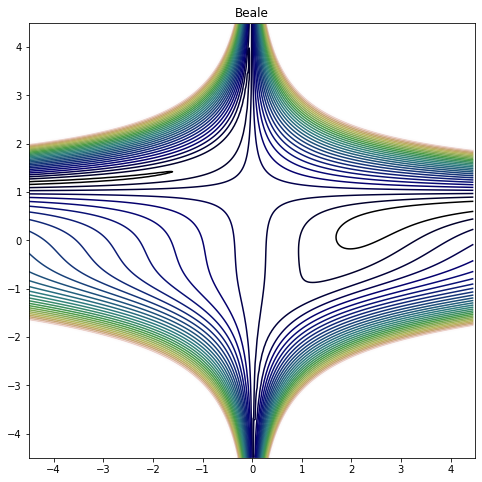

In [5]:
beale = lambda X, Y: ((1.5 - X + X*Y)**2 + (2.25 - X + X*Y**2)**2 + (2.625 - X + X*Y**3)**2)/30

X, Y = torch.meshgrid(torch.arange(-4.5, 4.5, 0.04), torch.arange(-4.5, 4.5, 0.02))

plt.figure(figsize=(8, 8))
plt.contour(X, Y, beale(X,Y), levels=np.arange(0, 6, 0.2)**2, cmap='gist_earth')
plt.gca().set_title('Beale')
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))
plt.show()

(-4.5, 4.5)

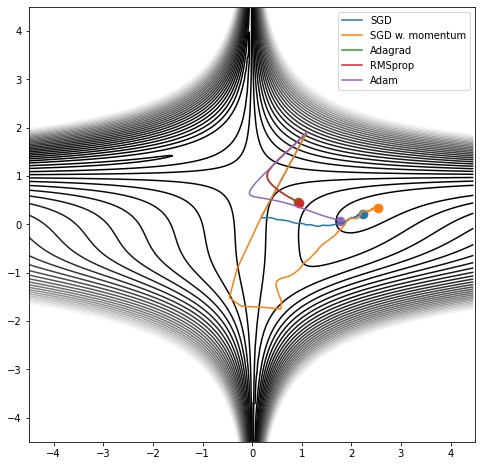

In [6]:
paths = train(beale, [1.1, 1.9], 100)

X, Y = torch.meshgrid(torch.arange(-4.5, 4.5, 0.04), torch.arange(-4.5, 4.5, 0.02))

plt.figure(figsize=(8, 8))
plt.contour(X, Y, beale(X,Y), levels=np.arange(0, 6, 0.2)**2, cmap='Greys_r')
plt.plot(paths[0,...,0], paths[0,...,1], label='SGD')
plt.plot(paths[1,...,0], paths[1,...,1], label='SGD w. momentum')
plt.plot(paths[2,...,0], paths[2,...,1], label='Adagrad')
plt.plot(paths[3,...,0], paths[3,...,1], label='RMSprop')
plt.plot(paths[4,...,0], paths[4,...,1], label='Adam')
s = 300
plt.scatter(paths[0, -1, 0], paths[0, -1, 1], s, marker='.')
plt.scatter(paths[1, -1, 0], paths[1, -1, 1], s, marker='.')
plt.scatter(paths[2, -1, 0], paths[2, -1, 1], s, marker='.')
plt.scatter(paths[3, -1, 0], paths[3, -1, 1], s, marker='.')
plt.scatter(paths[4, -1, 0], paths[4, -1, 1], s, marker='.')
plt.legend()
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))